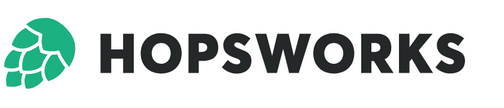


# Part 03: Model training & UI Exploration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_online/3_model_training.ipynb)

In this last notebook, you will train a model on the dataset you created in the previous tutorial. You will train the model using standard Python and Scikit-learn, although it could just as well be trained with other machine learning frameworks such as PySpark, TensorFlow, and PyTorch. You will also perform some of the exploration that can be done in Hopsworks, notably the search functions and the lineage.

## 🗒️ This notebook is divided in 5 main sections:
1. **Loading the training data**
2. **Train the model**
3. **Register model to Hopsworks model registry**.
4. **Deploy the model on KServe behind Hopsworks for real-time inference requests**.
5. **Test model deployment and use model serving rest APIs**.

![tutorial-flow](../images/03_model.png)

In [ ]:
!pip install -U hopsworks --quiet

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://hopsworks0.logicalclocks.com/p/119
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
feature_view = fs.get_feature_view("transactions_fraud_online_fv", 1)

## <span style="color:#ff5f27;"> ✨ Load Training Data </span>

First, you will need to fetch the training dataset that you created in the previous notebook. You will use January - February data training and testing.

In [13]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

train_jan_x, train_jan_y, test_feb_x, test_feb_y, val_mar_x, val_mar_y = feature_view.get_train_validation_test_split(1)

In [7]:
train_jan_y.value_counts(normalize=True)

fraud_label
0              0.996865
1              0.003135
dtype: float64

Notice that the distribution is extremely skewed, which is natural considering that fraudulent transactions make up a tiny part of all transactions. Thus you should somehow address the class imbalance. There are many approaches for this, such as weighting the loss function, over- or undersampling, creating synthetic data, or modifying the decision threshold. In this example, you will use the simplest method which is to just supply a class weight parameter to our learning algorithm. The class weight will affect how much importance is attached to each class, which in our case means that higher importance will be placed on positive (fraudulent) samples.

## <span style="color:#ff5f27;"> 🏃 Train Model</span>

Next you will train a model. Here, you set larger class weight for the positive class.

In [8]:
import numpy as np
from sklearn.ensemble import IsolationForest

# fit the model
clf = IsolationForest()
clf.fit(train_jan_x)

IsolationForest()

In [9]:
# Train Predictions
y_pred_train = clf.predict(train_jan_x)

In [12]:
# Test Predictions
y_pred_test = clf.predict(test_feb_x)

In [14]:
# Validation Predictions
y_pred_val = clf.predict(val_mar_x)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


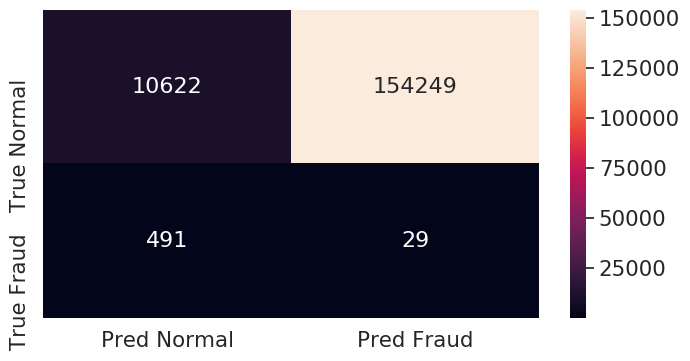

In [19]:
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot
import seaborn as sn

%matplotlib inline

if_cm=confusion_matrix(test_feb_y, y_pred_test)
pd.DataFrame(if_cm)
df_cm = pd.DataFrame(if_cm, ['step', 'True Normal',  'True Fraud'],['Pred Normal', 'step', 'Pred Fraud'])
df_cm.drop(index="step",inplace=True)
df_cm.drop("step", axis=1, inplace=True)

pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


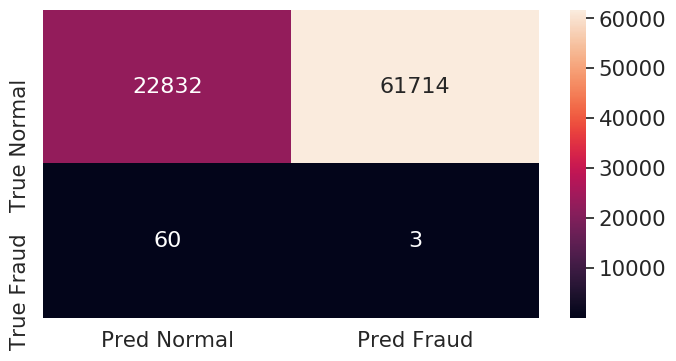

In [18]:
if_cm=confusion_matrix(val_mar_y, y_pred_val)
pd.DataFrame(if_cm)
df_cm = pd.DataFrame(if_cm, ['step', 'True Normal',  'True Fraud'],['Pred Normal', 'step', 'Pred Fraud'])
df_cm.drop(index="step",inplace=True)
df_cm.drop("step", axis=1, inplace=True)

pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [ ]:
from sklearn.metrics import f1_score
# Compute f1 score
metrics = {"fscore": f1_score(test_mar_y, y_pred_test, average='micro')}
metrics


## <span style="color:#ff5f27;"> Register model</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [20]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [21]:
import joblib
joblib.dump(clf, 'model.pkl')

['model.pkl']

The model needs to be set up with a Model Schema, which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [22]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(train_jan_x)
output_schema = Schema(train_jan_y)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'loc_delta_t_plus_1',
    'type': 'float64'},
   {'name': 'loc_delta_t_minus_1', 'type': 'float64'},
   {'name': 'time_delta_t_plus_1', 'type': 'float64'},
   {'name': 'time_delta_t_minus_1', 'type': 'float64'},
   {'name': 'country', 'type': 'int64'},
   {'name': 'cc_num', 'type': 'int64'},
   {'name': 'gender', 'type': 'int64'}]},
 'output_schema': {'columnar_schema': [{'name': 'fraud_label',
    'type': 'int64'}]}}

In [ ]:
test_credit_card = [test_mar_x.cc_num.values[0]]
model = mr.sklearn.create_model(
    name="transactions_fraud_online_model",
    metrics=metrics,
    description="Isolation forest anomaly detection model",
    input_example = test_credit_card,
    model_schema=model_schema
)

model.save('model.pkl')

## <span style="color:#ff5f27;"> Deploy model</span>
### About Model Serving
Models can be served via KFServing or "default" serving, which means a Docker container exposing a Flask server. For KFServing models, or models written in Tensorflow, you do not need to write a prediction file (see the section below). However, for sklearn models using default serving, you do need to proceed to write a prediction file.

In order to use KFServing, you must have Kubernetes installed and enabled on your cluster.

### Create the Prediction File
In order to deploy a model, you need to write a Python file containing the logic to return a prediction from the model. Don't worry, this is usually a matter of just modifying some paths in a template script. An example can be seen in the code block below, where we have taken this Scikit-learn template script and changed two paths (see comments).

In [ ]:
%%writefile predict_example.py
import os
import numpy as np
import hsfs
import joblib

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()
        
        # get feature views
        self.fv = self.fs.get_feature_view("transactions_fraud_online_fv", 1)
        
        # initialise serving
        self.fv.init_serving(1)

        # load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/model.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        return self.model.predict(np.asarray(self.fv.get_feature_vector({"cc_num": inputs[0]})).reshape(1, -1)).tolist() # Numpy Arrays are not JSON serializable


If you wonder why we use the path Models/fraud_tutorial_model/1/model.pkl, it is useful to know that the Data Sets tab in the Hopsworks UI lets you browse among the different files in the project. Registered models will be found underneath the Models directory. Since you saved you model with the name fraud_tutorial_model, that's the directory you should look in. 1 is just the version of the model you want to deploy.

This script needs to be put into a known location in the Hopsworks file system. Let's call the file predict_example.py and put it in the Models directory.

In [ ]:
import os
dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

## Create the deployment
Here, you fetch the model you want from the model registry and define a configuration for the deployment. For the configuration, you need to specify the serving type (default or KFserving).

In [ ]:
# Use the model name from the previous notebook.
model = mr.get_model("transactions_fraud_online_model", version=1)

# Give it any name you want
deployment = model.deploy(
    name="fraudonlinemodeldeployment", 
    model_server="PYTHON",
    serving_tool="KSERVE",
    script_file=predictor_script_path
)

In [ ]:
print("Deployment: " + deployment.name)
deployment.describe()

#### The deployment has now been registered. However, to start it you need to run the following command:

In [ ]:
deployment.start()

In [ ]:
# to troubleshoot deployment you can use `get_logs()` method
deployment.get_logs()

## 🚀 Test your Model with an Inference Request
Finally you can start making predictions with your model!

Send inference requests to the deployed model as follows:

In [ ]:
data = {
    "inputs": model.input_example
}

deployment.predict(data)

In [ ]:
# to troubleshoot you can use `get_logs()` method
deployment.get_logs()

### Retrieving you deployment and making a prediction


In [ ]:
ms = project.get_model_serving()
fraud_detector = ms.get_deployment("fraudonlinemodeldeployment")

In [ ]:
prediction = fraud_detector.predict(data)

In [ ]:
prediction

## Stop Deployment
To stop the deployment you simply run:

In [ ]:
deployment.stop()

## 👾 StreamLit App


If you want to see interactive dashboards - use a **StreamLit App**.

Type the next commands in terminal to run a Streamlit App:

`cd {%path_to_hopsworks_tutorials%}/`

`conda activate ./miniconda/envs/hopsworks`

`python -m streamlit run fraud_online/streamlit_app.py`


### <span style="color:#ff5f27;">🥳 <b> Next Steps  </b> </span>
Congratulations you've now completed the operational fraud detection tutorial for Managed Hopsworks.

Check out our other tutorials on ➡ https://github.com/logicalclocks/hopsworks-tutorials

Or documentation at ➡ https://docs.hopsworks.ai